## Import Needed Packages

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# for Imputer packages
!pip install scikit-learn

In [2]:
# dependency for fbprophet
!pip install pystan

In [3]:
# for installing in anaconda's jupyter notebook, can also use
# !pip install fbprophet
conda install -c conda-forge fbprophet

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# interactive plotting package for FB Prophet
!pip install plotly==4.5.2

## Importing Data
### Need to save each worksheet in the Case Data.xlsx file as a separate csv file 
##### "Load" was saved as "Load.csv", Price as "Price.csv", and "BatterySchedule" as "BatterySchedule.csv"

##### Read and Saved each .csv file as a Pandas DataFrame

In [2]:
# Load data 
load_data = pd.read_csv("Load.csv")
# load_data.head()

In [3]:
# Price data
price_data = pd.read_csv("Price.csv")
#price_data.head()

In [4]:
# Battery data
battery_data = pd.read_csv("BatterySchedule.csv")
# battery_data.head()

## Cleaning and Pre-processing Data

#### Check for Missing Data

In [93]:
# initiate variables to find missing data for Load, Price, and Battery

missing_data_load = load_data.isnull()
missing_data_price = price_data.isnull()
missing_data_battery = battery_data.isnull()
#missing_data_load.head(5)

In [94]:
# Print number of missing data in each column for load 
for column in missing_data_load.columns.values.tolist():
    print(column)
    print (missing_data_load[column].value_counts())
    print("")    

ID
False    2976
Name: ID, dtype: int64

Timestamp Beginning
False    2976
Name: Timestamp Beginning, dtype: int64

Timestamp Ending
False    2976
Name: Timestamp Ending, dtype: int64

Date
False    2976
Name: Date, dtype: int64

HourEnding
False    2976
Name: HourEnding, dtype: int64

15Min Load
False    2976
Name: 15Min Load, dtype: int64



In [ ]:
# initiate variable to find missing data for Price

missing_data_price = price_data.isnull()
#missing_data_price.head(5)

In [ ]:
# Print number of missing data in each column for Price 
for column in missing_data_price.columns.values.tolist():
    print(column)
    print (missing_data_price[column].value_counts())
    print("")  

In [ ]:
# initiate variable to find missing data for BatterySchedule

missing_data_battery = battery_data.isnull()
#missing_data_battery.head(5)

In [12]:
# Print number of missing data in each column for Price 
for column in missing_data_battery.columns.values.tolist():
    print(column)
    print (missing_data_battery[column].value_counts())
    print("")  

ID
False    2976
Name: ID, dtype: int64

TimeStamp Beginning
False    2976
Name: TimeStamp Beginning, dtype: int64

Timestamp Ending
False    2976
Name: Timestamp Ending, dtype: int64

Date
False    2976
Name: Date, dtype: int64

Hour
False    2976
Name: Hour, dtype: int64

15Min Inverter
False    2436
True      540
Name: 15Min Inverter, dtype: int64



#### Dealing with Missing Data
##### Value for NCP is not substituted in the HOEP column entry (corresponds to highest hourly value of _Load_) to ease the process by avoiding  an outlier

In [5]:
# Copies features into lists with hourly values
# Appends lists into df DataFrame

load = load_data["15Min Load"]
load_sum = [None]*(len(load)//4)
i = 0
for j in range(0,len(load),4):
    load_sum[i]= sum(load[j:j+4])
    i = i+1

print(load_sum[0:5])

price = price_data["HOEP"]
HOEP = [None]*len(load_sum)
m = 0 
for n in range(0,len(price),1):
    HOEP[m] = price[n]/100
    m = m + 1

print(HOEP[0:5])

battery = battery_data["15Min Inverter"]
battery_sum = [None]*(len(battery)//4)
x = 0
for y in range(0,len(battery),4):
    battery_sum[x]= sum(battery[y:y+4])
    x = x + 1

print(battery_sum[0:5])

hour_list = price_data["Hour"]
hour = [None]*len(hour_list)
g = 0 
for h in range(0,len(price),1):
    hour[g] = hour_list[h]
    g = g + 1

print(hour[0:5])
    
df = pd.DataFrame(hour, columns=["Hour"])
df["Load"] = load_sum
df["HOEP"] = price_data["HOEP"]/100
df['Inverter'] = battery_sum

df.head()


[1268.16, 1273.92, 1265.28, 661.4399999999999, 837.12]
[-0.0006, -0.0229, -0.03, -0.029300000000000003, -0.008100000000000001]
[-600.0, -600.0, -10.0, 0.0, 0.0]
[1, 2, 3, 4, 5]


,Hour,Load,HOEP,Inverter
0,1,1268.16,-0.0006,-600.0
1,2,1273.92,-0.0229,-600.0
2,3,1265.28,-0.0300,-10.0
3,4,661.44,-0.0293,0.0
4,5,837.12,-0.0081,0.0


In [6]:
# Counts missing data in df

missing_data_df = df.isnull()
for column in missing_data_df.columns.values.tolist():
    print(column)
    print (missing_data_df[column].value_counts())
    print("")  

Hour
False    744
Name: Hour, dtype: int64

Load
False    744
Name: Load, dtype: int64

HOEP
False    744
Name: HOEP, dtype: int64

Inverter
False    609
True     135
Name: Inverter, dtype: int64



In [83]:
# Initiates hourly variable to test Imputers, can change variable to other hourly values
# Duplicates df and names copy df_new

hour_stamp = 2
index = df[df["Hour"]==hour_stamp].index.values

df_new = df.iloc[index]
df_new.head()
    

,Hour,Load,HOEP,Inverter
1,2,1273.92,-0.0229,-600.0
25,2,1302.72,-0.0007,-616.0
49,2,652.80,-0.0300,0.0
73,2,650.88,-0.0216,0.0
97,2,688.32,0.0000,0.0


##### Multivariate and KNN Imputers are tested to find the missing values

In [89]:
# Multivariate Imputer
# Fits and Predicts values for missing data 
# Can alter values for max_iter and random_state, but no changes were observed 
# Predicted values are shown in entries from 23 to 28


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
iter_imp = IterativeImputer(max_iter=10, random_state=0)
df_fit_iter = pd.DataFrame(iter_imp.fit_transform(df_new), columns = ["Hour","Load","HOEP","Inverter Dispatch"])
df_fit_iter[20:31]

,Hour,Load,HOEP,Inverter Dispatch
20,2.0,682.56,-0.0078,0.000000
21,2.0,675.84,-0.0300,0.000000
22,2.0,646.08,-0.0300,0.000000
23,2.0,669.12,-0.0300,11.423217
24,2.0,676.80,0.0284,4.007815
25,2.0,633.60,-0.0385,45.722354
26,2.0,672.96,-0.0300,7.715192
27,2.0,674.88,0.0000,5.861513
28,2.0,667.20,-0.0300,13.277229
29,2.0,657.60,0.1094,0.000000


In [91]:
# KNN Imputer
# Fits and Predicts values for missing data 
# Can alter values for n_neighbors, but no changes were observed unless n value is large 
# Predicted values are shown in entries from 23 to 28

from sklearn.impute import KNNImputer
knn_imp = KNNImputer(n_neighbors=5)
df_fit_knn = pd.DataFrame(knn_imp.fit_transform(df_new), columns = ["Hour","Load","HOEP","Inverter Dispatch"])
df_fit_knn[15:31]

,Hour,Load,HOEP,Inverter Dispatch
15,2.0,1023.36,-0.0234,-336.0
16,2.0,669.12,-0.0013,0.0
17,2.0,674.88,0.0427,0.0
18,2.0,676.80,0.0564,0.0
19,2.0,684.48,-0.0021,0.0
20,2.0,682.56,-0.0078,0.0
21,2.0,675.84,-0.0300,0.0
22,2.0,646.08,-0.0300,0.0
23,2.0,669.12,-0.0300,0.0
24,2.0,676.80,0.0284,0.0


#### Since neither imputer's predictions for the missing values make sense, let's try the Prophet Time Series Forcasting ML model 

In [95]:
# Copies Time_stamp Ending feature into a list

stamp = battery_data["Timestamp Ending"]
time_stamp = [None]*len(load_sum)
p = 0 
for q in range(3,len(stamp),4):
    time_stamp[p] = stamp[q]
    p = p + 1

print(time_stamp[0:5])

['10/1/2019 1:00', '10/1/2019 2:00', '10/1/2019 3:00', '10/1/2019 4:00', '10/1/2019 5:00']


In [8]:
# Creates new DataFrame df1 which includes the time_stamp feature 

df1 = pd.DataFrame(time_stamp, columns=["Timestamp Ending"])
df1['Inverter'] = battery_sum
df1["Load"] = load_sum
df1["HOEP"] = price_data["HOEP"]/100

df1.head()

,Timestamp Ending,Inverter,Load,HOEP
0,10/1/2019 1:00,-600.0,1268.16,-0.0006
1,10/1/2019 2:00,-600.0,1273.92,-0.0229
2,10/1/2019 3:00,-10.0,1265.28,-0.0300
3,10/1/2019 4:00,0.0,661.44,-0.0293
4,10/1/2019 5:00,0.0,837.12,-0.0081


In [9]:
# Renames features to begin using FB Prophet 

df1.rename(columns={"Timestamp Ending":"ds","Inverter":"y"}, inplace = True)
df1.head()

,ds,y,Load,HOEP
0,10/1/2019 1:00,-600.0,1268.16,-0.0006
1,10/1/2019 2:00,-600.0,1273.92,-0.0229
2,10/1/2019 3:00,-10.0,1265.28,-0.0300
3,10/1/2019 4:00,0.0,661.44,-0.0293
4,10/1/2019 5:00,0.0,837.12,-0.0081


In [10]:
# Changes data type of ds column into the appropriate format datetime64

df1["ds"] = df1["ds"].astype("datetime64[ns]") 
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 4 columns):
ds      744 non-null datetime64[ns]
y       609 non-null float64
Load    744 non-null float64
HOEP    744 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 23.3 KB


In [11]:
# Splits the data into \
# a train set which includes the available data minus the last portion after the missing data and \
# a test set which includes the missing data and the subsequent available data
# The predicted values for the available data portion in the test set will not be used 

df1_train = df1.loc[df1["ds"]<"10/23/2019 20:00"]
df1_test  = df1.loc[df1["ds"]>="10/23/2019 20:00"]

In [78]:
# Imports Prophet 
# Adds additional features / regressors Load and HOEP in the model 
# Model is trained using the train set 

from fbprophet import Prophet
model = Prophet()
model.add_regressor('Load')
model.add_regressor('HOEP')
model.fit(df1_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [79]:
# Model uses the test set to predict values for the missing data
# Predicted values are stored in the "yhat" column

df1_test_fcst = model.predict(df1_test)
df1_test_fcst[0:136]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,HOEP,HOEP_lower,HOEP_upper,Load,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-10-23 20:00:00,-11.725818,-170.845623,151.686586,-11.725818,-11.725818,-0.052192,-0.052192,-0.052192,-0.970285,...,-1.022477,-1.022477,-1.022477,46.005874,46.005874,46.005874,0.0,0.0,0.0,-19.968495
1,2019-10-23 21:00:00,-11.753730,-203.880649,112.745468,-11.753730,-11.753730,-4.701024,-4.701024,-4.701024,29.777861,...,25.076836,25.076836,25.076836,46.765606,46.765606,46.765606,0.0,0.0,0.0,-42.569109
2,2019-10-23 22:00:00,-11.781641,-219.295848,101.291502,-11.781641,-11.781641,-4.709026,-4.709026,-4.709026,41.750590,...,37.041564,37.041564,37.041564,47.223107,47.223107,47.223107,0.0,0.0,0.0,-66.129083
3,2019-10-23 23:00:00,-11.809552,-250.021287,74.338680,-11.809552,-11.809552,-5.821225,-5.821225,-5.821225,44.471665,...,38.650440,38.650440,38.650440,47.369370,47.369370,47.369370,0.0,0.0,0.0,-81.986196
4,2019-10-24 00:00:00,-11.837464,-243.555451,74.092460,-11.837464,-11.837464,-6.413331,-6.413331,-6.413331,43.383235,...,36.969904,36.969904,36.969904,47.199457,47.199457,47.199457,0.0,0.0,0.0,-80.746177
5,2019-10-24 01:00:00,-11.865375,-237.458644,109.102486,-11.865375,-11.865375,-6.613367,-6.613367,-6.613367,44.199557,...,37.586190,37.586190,37.586190,46.712558,46.712558,46.712558,0.0,0.0,0.0,-57.530752
6,2019-10-24 02:00:00,-11.893287,-191.619878,139.650533,-11.893287,-11.893287,-7.101454,-7.101454,-7.101454,42.702966,...,35.601512,35.601512,35.601512,45.911998,45.911998,45.911998,0.0,0.0,0.0,-23.034110
7,2019-10-24 03:00:00,-11.921198,-157.178048,186.651717,-11.921198,-11.921198,-7.101454,-7.101454,-7.101454,43.791396,...,36.689942,36.689942,36.689942,44.805181,44.805181,44.805181,0.0,0.0,0.0,17.138399
8,2019-10-24 04:00:00,-11.949109,-125.582401,200.000630,-11.949109,-11.949109,-7.101454,-7.101454,-7.101454,29.913915,...,22.812460,22.812460,22.812460,43.403493,43.403493,43.403493,0.0,0.0,0.0,32.404677
9,2019-10-24 05:00:00,-11.977021,-109.135257,220.212210,-11.977021,-11.977021,-6.909420,-6.909420,-6.909420,35.900279,...,28.990859,28.990859,28.990859,41.722136,41.722136,41.722136,0.0,0.0,0.0,51.324627


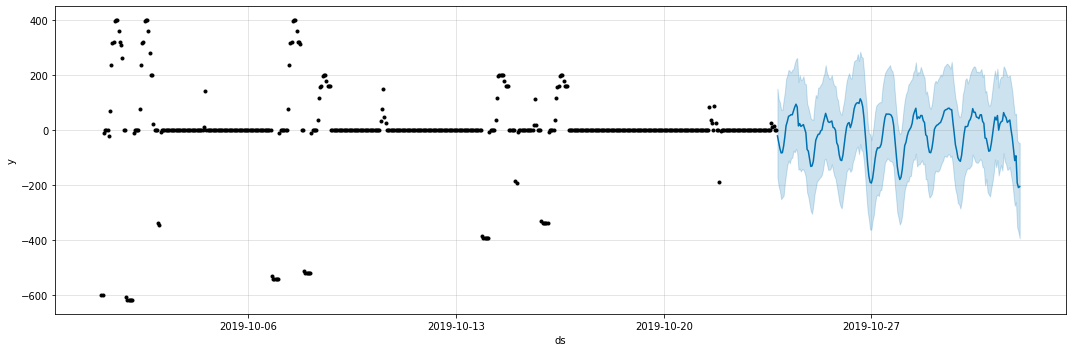

In [80]:
# Plot the forecast
# Predicted values are in blue 

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df1_test_fcst,
                 ax=ax)
plt.show()

In [96]:
# Saves the data in the yhat column as a .csv file

battery_yhat = df1_test_fcst['yhat'][0:136]
battery_yhat.tail()
yhat = battery_yhat.to_frame()

yhat.to_csv(r'C:\Users\sonle\Desktop\yhat.csv', index = False)

In [97]:
# Saves the df Dataframe into a .csv file

df.to_csv(r'C:\Users\sonle\Desktop\df.csv', index = False)

### The predicted values in the yhat.csv file are manually filled in where the missing data is in the df.csv file.
### The changes are saved in the final_df.csv file

In [28]:
# Import final_df.csv file and stores data in DataFrame final_df
# Check for missing data

final_df = pd.read_csv("final_df.csv")
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 4 columns):
Hour        744 non-null int64
Load        744 non-null float64
HOEP        744 non-null float64
Inverter    744 non-null float64
dtypes: float64(3), int64(1)
memory usage: 23.3 KB


In [29]:
final_df.head()

,Hour,Load,HOEP,Inverter
0,1,1268.16,-0.0006,-600.0
1,2,1273.92,-0.0229,-600.0
2,3,1265.28,-0.0300,-10.0
3,4,661.44,-0.0293,0.0
4,5,837.12,-0.0081,0.0


## Total Cost without Battery Dispatch

In [46]:
# Copies features Load and HOEP from final_df into lists with hourly values
# Calculates the individual hourly costs and stores them in a list

load_fin = final_df["Load"]
load_sum_fin = [None]*len(load_fin)
i = 0
for j in range(0,len(load_fin),1):
    load_sum_fin[i]= load_fin[j]
    i = i+1

print(load_sum_fin[0:5])

price_fin = final_df["HOEP"]
HOEP_fin = [None]*len(load_fin)
m = 0 
for n in range(0,len(price_fin),1):
    HOEP_fin[m] = price_fin[n]
    m = m + 1

print(HOEP_fin[0:5])

cost_col = [None]*len(load_fin)
a = 0
for a in range(0,len(cost_col)):
    cost_col[a] = load_sum_fin[a] * HOEP_fin[a]
    a = a + 1

print(cost_col[0:5])

[1268.16, 1273.92, 1265.28, 661.44, 837.12]
[-0.0006, -0.0229, -0.03, -0.0293, -0.0081]
[-0.760896, -29.172768, -37.9584, -19.380192, -6.780672]


In [48]:
# Creates a new DataFrame costs_without_battery to store relevant information

cost_without_battery = pd.DataFrame(load_sum_fin, columns=['Load'])
cost_without_battery["HOEP"] = final_df["HOEP"]
cost_without_battery["Cost"] = cost_col
cost_without_battery.head()

,Load,HOEP,Cost
0,1268.16,-0.0006,-0.760896
1,1273.92,-0.0229,-29.172768
2,1265.28,-0.0300,-37.958400
3,661.44,-0.0293,-19.380192
4,837.12,-0.0081,-6.780672


In [58]:
# Finds the instance and index with the max Load value 
# Prints the index
# Prints the entry 

max_load = cost_without_battery["Load"].max()
NCP_index = cost_without_battery[cost_without_battery["Load"]==max_load].index.values
print("The maximum value's index is:", NCP_index[0])
cost_without_battery[NCP_index[0]:NCP_index[0]+1]

The maximum value's index is: 564


,Load,HOEP,Cost
564,1680.96,0.0008,1.344768


In [59]:
# Initializes NCP variable
# Calculates NPC-driven cost using the max load value 
# Replaces it in the correct entry in cost_without_battery

NCP = 11.25
cost_NCP = max_load * NCP
cost_without_battery.loc[NCP_index[0],"Cost"] = cost_NCP
cost_without_battery[NCP_index[0]:NCP_index[0]+1]

,Load,HOEP,Cost
564,1680.96,0.0008,18910.8


In [63]:
# Calculates and prints the total montly cost without battery

total_cost_no_bat = cost_without_battery["Cost"].sum()
print("The total utlity cost without battery dispatch is: {0:5.2f}".format(total_cost_no_bat), "CAD")

The total utlity cost without battery dispatch is: 73237.27 CAD


## Total Cost with Battery Dispatch

In [67]:
# Copies features Inverter from final_df into a list with hourly values\
# Calculates the Adjusted load by substracting Inverter values from Load valeus
# Calculates the individual hourly costs and stores them in a list

battery_fin = final_df["Inverter"]
battery_sum_fin = [None]*len(battery_fin)
x = 0
for y in range(0,len(battery_fin),1):
    battery_sum_fin[x]= battery_fin[y]
    x = x + 1
    
adjusted_load = [None]*len(load_sum_fin)
for e in range(0,len(adjusted_load)):
    adjusted_load[e] = load_sum_fin[e] - battery_sum_fin[e]
    e = e + 1

cost_col_new = [None]*len(battery_fin)
z = 0
for z in range(0,len(cost_col_new)):
    cost_col_new[z] = adjusted_load[z] * HOEP_fin[z]
    z = z + 1

cost_with_battery = pd.DataFrame(load_sum_fin, columns=['Load'])
cost_with_battery["Battery Dispatch"] = battery_sum_fin
cost_with_battery["Load after Dispatch"] = adjusted_load
cost_with_battery["HOEP"] = final_df["HOEP"]
cost_with_battery["Cost"] = cost_col_new
cost_with_battery.head()

,Load,Battery Dispatch,Load after Dispatch,HOEP,Cost
0,1268.16,-600.0,1868.16,-0.0006,-1.120896
1,1273.92,-600.0,1873.92,-0.0229,-42.912768
2,1265.28,-10.0,1275.28,-0.0300,-38.258400
3,661.44,0.0,661.44,-0.0293,-19.380192
4,837.12,0.0,837.12,-0.0081,-6.780672


In [68]:
# Finds the instance and index with the greatest Load value 
# Prints the index
# Prints the entry 

max_load_new = cost_with_battery["Load after Dispatch"].max()
NCP_index_new = cost_with_battery[cost_with_battery["Load after Dispatch"]==max_load_new].index.values
print("The new maximum value's index is:", NCP_index_new[0])
cost_with_battery[NCP_index_new[0]:NCP_index_new[0]+1]

The new maximum value's index is: 21


,Load,Battery Dispatch,Load after Dispatch,HOEP,Cost
21,1310.4,-616.0,1926.4,0.1611,310.34304


In [69]:
# Initializes NCP variable
# Calculates NPC-driven cost using the max load value 
# Replaces it in the correct entry in cost_without_battery

cost_NCP_new = max_load_new * NCP
cost_with_battery.loc[NCP_index_new[0],"Cost"] = cost_NCP_new
cost_with_battery[NCP_index_new[0]:NCP_index_new[0]+1]

,Load,Battery Dispatch,Load after Dispatch,HOEP,Cost
21,1310.4,-616.0,1926.4,0.1611,21672.0


In [73]:
# Calculates and prints the total montly cost with battery

total_cost_bat = cost_with_battery["Cost"].sum()
print("The total utlity cost with battery dispatch is: {0:5.2f}".format(total_cost_bat), "CAD")

The total utlity cost with battery dispatch is: 74262.93 CAD


In [74]:
# Calculates and prints the customer's monthly savings

savings = total_cost_no_bat - total_cost_bat
print("The total savings for using the battery is: {0:5.2f}".format(savings), "CAD")

The total savings for using the battery is: -1025.66 CAD
